In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all confernece wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

In [4]:
# Compare the conferences of two teams playing in a game.
# If both teams are in power conference or both teams are not in a power conference return 0.
# If the opponent team is in a power conference and the first team is not in a power conference return -1
# If the first team is a power conference team and opponent is not then return 1.

def conf_compare(team_conf, opp_conf):
    team_top = team_conf in top_tournament_conferences_list
    opp_top = opp_conf in top_tournament_conferences_list
    if team_top == opp_top:
        return 0
    elif team_top :
        return 1
    else:
        return -1

In [5]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [6]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [7]:
def get_tournament_record(df, season, round_, team):
    return df[(df['season_t'] == season) & (df['round']== round_) & (df['team']==team)]


In [8]:
def print_game_info(df, season, round_, team):
    t_rec = get_tournament_record(df, season, round_, team)
    opp_team = t_rec['opp_team'].iloc[0]
    print('\t\t',team,'\t',opp_team)
    print('Seed','\t\t',"%6d"%t_rec['team_seed'].iloc[0],'\t',"%6d"%t_rec['opp_team_seed'].iloc[0])
    print('PPG','\t\t',"%6.2f"%t_rec['points_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['points_avg_o'].iloc[0])
    print('Allow PPG','\t',"%6.2f"%t_rec['opp_pts_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['opp_pts_avg_o'].iloc[0])
    print('Poss Avg','\t',"%6.2f"%t_rec['possesion_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['possesion_avg_o'].iloc[0])
    print('FG %','\t\t',"%6.2f"%(100*t_rec['fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['fg_pct_o'].iloc[0]))
    print('Allow FG %','\t',"%6.2f"%(100*t_rec['allow_fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['allow_fg_pct_o'].iloc[0]))
    print('Off Rb Avg','\t',"%6.2f"%t_rec['off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rebs_avg_o'].iloc[0])
    print('Allow Off Rb Avg',"%6.2f"%t_rec['allow_off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_off_rebs_avg_o'].iloc[0])
    print('Def Rb Avg','\t',"%6.2f"%t_rec['def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['def_rebs_avg_o'].iloc[0])
    print('Allow Def Rb Avg',"%6.2f"%t_rec['allow_def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_def_rebs_avg_o'].iloc[0])  
    print('FT ATT Avg','\t',"%6.2f"%t_rec['ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['ft_att_avg_o'].iloc[0]) 
    print('Allow FT ATT Avg',"%6.2f"%t_rec['allow_ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_ft_att_avg_o'].iloc[0])
    print('FT %','\t\t',"%6.2f"%(100*t_rec['ft_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['ft_pct_o'].iloc[0]))
    print('Turnover Avg','\t',"%6.2f"%t_rec['turnover_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['turnover_avg_o'].iloc[0])
    print('Takeaway Avg','\t',"%6.2f"%t_rec['take_away_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['take_away_avg_o'].iloc[0])
    print('Win %','\t\t',"%6.2f"%(100*t_rec['win_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['win_pct_o'].iloc[0]))
    print('Off Rating','\t',"%6.2f"%t_rec['off_rating_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rating_o'].iloc[0])
    print('\n\nTop Conference= ', t_rec['top_conf'].iloc[0])
    print('Game Result= ', t_rec['game_result'].iloc[0], ' (One indicates win for ', team,')')
    print('Predicted Result= ', t_rec['predicted_result'].iloc[0])
    print('Predicted Probability= ',"%6.3f"%t_rec['pred_win_prob'].iloc[0])
    return

In [9]:
#read in cumulative team data from seasons 2013 to 2017 
#Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv('season_sum_cumulative.csv')
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(1755, 19)


,market,season,team_id,points_avg,opp_pts_avg,possesion_avg,fg_pct,allow_fg_pct,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,ft_att_avg,allow_ft_att_avg,ft_pct,turnover_avg,take_away_avg,win_pct,off_rating
1749,Portland State,2013,79965018-7f6f-4273-9eef-65c99b592b01,71.433333,73.433333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN
1750,St. Francis (PA),2013,6637ac5f-59c2-4888-af34-a86d138ccfb3,61.806452,69.354839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322581,NaN
1751,Montana State,2013,bec40585-b587-4548-93f5-b7c00b046aea,65.206897,70.068966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413793,NaN
1752,UC Riverside,2013,6b170a32-8445-4cb1-8638-724996c3094b,66.892857,72.142857,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.285714,NaN
1753,Central Michigan,2013,472c22e0-843d-472c-a871-f1593fb0725d,69.586207,75.689655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275862,NaN
1754,Incarnate Word,2013,912671c7-19fd-451b-813e-885485427820,76.800000,74.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,NaN


In [10]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(1749, 19)


In [11]:
# Read table of team names and associated team meta data
teams = pd.read_csv('D1_teams.csv')
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


In [12]:
tourney_data = pd.read_csv('tournament_results.csv')
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


### Extract some historical data

In [13]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [14]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [15]:
tourney_data.describe()['season']

count    2117.000000
mean     2001.193198
std         9.563883
min      1985.000000
25%      1993.000000
50%      2001.000000
75%      2010.000000
max      2017.000000
Name: season, dtype: float64

Note the tournament data is available for tournament years 1985 through 2017.

In [16]:
summary_data.describe()['season']

count    1749.000000
mean     2015.006861
std         1.412173
min      2013.000000
25%      2014.000000
50%      2015.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

The summary season data is available from 2013 through 2017.

So the intersection of season summary data with tournament data are seasons 2013-2014, 2014-2015, 2015-2016, 2016-2017.

In [17]:
summary_data = summary_data[(summary_data['season'] >= 2013) & (summary_data['season'] < 2017) ]
summary_data.describe()['season']

count    1398.000000
mean     2014.506438
std         1.116494
min      2013.000000
25%      2014.000000
50%      2015.000000
75%      2016.000000
max      2016.000000
Name: season, dtype: float64

In [18]:
tourney_data = tourney_data[tourney_data['season'] >= 2014]
tourney_data.describe()['season']

count     268.000000
mean     2015.500000
std         1.120126
min      2014.000000
25%      2014.750000
50%      2015.500000
75%      2016.250000
max      2017.000000
Name: season, dtype: float64

In [19]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 36 to 2034
Data columns (total 9 columns):
season          268 non-null int64
round           268 non-null int64
game_date       268 non-null object
win_seed        268 non-null int64
win_market      268 non-null object
win_team_id     268 non-null object
lose_seed       268 non-null int64
lose_market     268 non-null object
lose_team_id    268 non-null object
dtypes: int64(4), object(5)
memory usage: 20.9+ KB


In [20]:
tourney_data.reset_index()
tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f
44,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d
46,2015,64,2015-03-19,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf
48,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f
49,2015,32,2015-03-21,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600


In [21]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,2015
44,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016
46,2015,64,2015-03-19,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,1,2014
48,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015
49,2015,32,2015-03-21,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2014
72,2017,64,2017-03-17,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,14,New Mexico State,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,1,2016
73,2017,32,2017-03-19,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,1,2016
80,2014,64,2014-03-21,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,11,Nebraska,f8b1bf00-5b73-4ac4-98c0-ec554027ae32,1,2013
81,2014,32,2014-03-23,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,3,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2013
82,2014,64,2014-03-21,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,1,2013


In [22]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
36,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015
44,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016
46,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014
48,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015
49,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014


In [23]:

tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
#tourney_data.info()

In [24]:
#tourney_data.head()

In [25]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [26]:
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o
0,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015,Oregon State,71.838710,70.709677,67.269882,0.438724,0.431779,8.677419,9.741935,22.193548,23.870968,21.193548,22.000000,0.680365,11.064516,13.193548,0.580645,106.791788,Virginia Commonwealth,2015,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,77.250000,67.777778,69.932659,0.451296,0.440627,10.666667,8.083333,23.583333,23.138889,20.027778,20.222222,0.692094,11.333333,14.722222,0.694444,110.463411
1,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016,Rhode Island,73.628571,65.371429,66.839573,0.453915,0.406183,10.457143,8.514286,23.771429,22.028571,22.600000,24.142857,0.667509,10.628571,12.714286,0.714286,110.157154,Creighton,2016,7d797407-623e-476d-b299-46de4275414d,81.264706,72.941176,72.844691,0.504373,0.438316,6.647059,9.500000,25.029412,23.823529,16.911765,17.794118,0.683478,12.294118,13.441176,0.705882,111.558859
2,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Stephen F. Austin,78.032258,65.225806,67.621122,0.487962,0.442408,10.225806,8.000000,21.064516,18.064516,23.032258,24.225806,0.733894,13.451613,16.258065,0.838710,115.396277,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,76.085714,69.371429,67.893700,0.483704,0.421273,8.171429,8.685714,25.057143,20.457143,20.942857,14.171429,0.724420,11.971429,10.228571,0.742857,112.065942,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,74.454545,71.424242,69.086585,0.432080,0.423374,9.696970,9.000000,23.787879,24.939394,22.787879,25.484848,0.698138,10.424242,14.606061,0.696970,107.769902
4,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Georgetown,70.909091,65.242424,65.337318,0.455790,0.406760,9.787879,8.575758,22.515152,19.939394,23.303030,22.909091,0.703511,12.393939,12.909091,0.666667,108.527704,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520


Incorporate additional features here.
Team conference, seeding deltas.

In [27]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [28]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,conf_name_t,conf_name_o
0,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015,Oregon State,71.838710,70.709677,67.269882,0.438724,0.431779,8.677419,9.741935,22.193548,23.870968,21.193548,22.000000,0.680365,11.064516,13.193548,0.580645,106.791788,Virginia Commonwealth,2015,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,77.250000,67.777778,69.932659,0.451296,0.440627,10.666667,8.083333,23.583333,23.138889,20.027778,20.222222,0.692094,11.333333,14.722222,0.694444,110.463411,Pacific 12,Atlantic 10
1,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016,Rhode Island,73.628571,65.371429,66.839573,0.453915,0.406183,10.457143,8.514286,23.771429,22.028571,22.600000,24.142857,0.667509,10.628571,12.714286,0.714286,110.157154,Creighton,2016,7d797407-623e-476d-b299-46de4275414d,81.264706,72.941176,72.844691,0.504373,0.438316,6.647059,9.500000,25.029412,23.823529,16.911765,17.794118,0.683478,12.294118,13.441176,0.705882,111.558859,Atlantic 10,Big East
2,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Stephen F. Austin,78.032258,65.225806,67.621122,0.487962,0.442408,10.225806,8.000000,21.064516,18.064516,23.032258,24.225806,0.733894,13.451613,16.258065,0.838710,115.396277,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520,Southland,Pacific 12
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,76.085714,69.371429,67.893700,0.483704,0.421273,8.171429,8.685714,25.057143,20.457143,20.942857,14.171429,0.724420,11.971429,10.228571,0.742857,112.065942,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,74.454545,71.424242,69.086585,0.432080,0.423374,9.696970,9.000000,23.787879,24.939394,22.787879,25.484848,0.698138,10.424242,14.606061,0.696970,107.769902,Pacific 12,Mountain West
4,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Georgetown,70.909091,65.242424,65.337318,0.455790,0.406760,9.787879,8.575758,22.515152,19.939394,23.303030,22.909091,0.703511,12.393939,12.909091,0.666667,108.527704,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520,Big East,Pacific 12


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [29]:
print(top_tournament_conferences_list)
tourney_data['top_conf'] = tourney_data.apply(lambda row: conf_compare(row.conf_name_t, row.conf_name_o),axis=1)
tourney_data.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Pacific 12,Atlantic 10,1
1,1,Atlantic 10,Big East,0
2,0,Southland,Pacific 12,-1
3,1,Pacific 12,Mountain West,1
4,0,Big East,Pacific 12,-1
5,1,Big 12,Western Athletic,1
6,0,Pacific 12,Big 12,0
7,1,Big 12,Big Ten,0
8,0,Big East,Big 12,-1
9,1,Southern,Atlantic Coast,-1


In [30]:
numeric_feature_to_scale = ['points_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'turnover_avg_t','take_away_avg_t',
                            'off_rating_t',
                            'points_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'turnover_avg_o','take_away_avg_o',
                            'off_rating_o']

scaler =StandardScaler()
tourney_data[numeric_feature_to_scale] = scaler.fit_transform(tourney_data[numeric_feature_to_scale])
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,conf_name_t,conf_name_o,top_conf
0,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015,Oregon State,-0.557336,0.924388,67.269882,0.438724,0.431779,-0.459606,0.847134,-0.789773,1.394925,-0.076683,0.894078,0.680365,-0.104031,0.469905,0.580645,-0.973548,Virginia Commonwealth,2015,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0.501380,0.286109,69.932659,0.451296,0.440627,0.680630,-0.557232,-0.013434,0.906110,-0.438793,0.459041,0.692094,0.052749,1.438110,0.694444,-0.252820,Pacific 12,Atlantic 10,1
1,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016,Rhode Island,-0.198193,-0.151253,66.839573,0.453915,0.406183,0.565941,-0.194661,0.079337,0.384277,0.465590,1.540790,0.667509,-0.424452,0.208262,0.714286,-0.283632,Creighton,2016,7d797407-623e-476d-b299-46de4275414d,1.310987,1.307108,72.844691,0.504373,0.438316,-1.608590,0.576750,0.665496,1.262924,-1.469369,-0.287616,0.683478,0.730009,0.688836,0.705882,-0.023962,Atlantic 10,Big East,0
2,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Stephen F. Austin,0.685426,-0.180596,67.621122,0.487962,0.442408,0.432636,-0.631089,-1.411655,-1.790209,0.632252,1.565824,0.733894,1.650495,2.142914,0.838710,0.790414,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,Southland,Pacific 12,-1
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,0.294843,0.654735,67.893700,0.483704,0.421273,-0.751177,-0.049185,0.787520,-0.477732,-0.173340,-1.468577,0.724420,0.562554,-1.148762,0.742857,0.107679,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,-0.062352,1.007152,69.086585,0.432080,0.423374,0.128374,0.176521,0.082600,1.844478,0.474070,2.077331,0.698138,-0.588073,1.370168,0.696970,-0.815542,Pacific 12,Mountain West,1
4,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Georgetown,-0.743868,-0.177247,65.337318,0.455790,0.406760,0.180285,-0.142496,-0.612631,-0.761743,0.736652,1.168440,0.703511,0.873101,0.314611,0.666667,-0.617677,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,Big East,Pacific 12,-1


In [31]:

feature_data = tourney_data.drop(columns=['season_t','round','game_date','team','team_id_t',
                                         'opp_team','opp_team_id','game_result','start_season',
                                         'market_t','market_o','season_o','team_id_o',
                                         'conf_name_t','conf_name_o']).copy()
feature_data.head()

,team_seed,opp_team_seed,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,top_conf
0,7,10,-0.557336,0.924388,67.269882,0.438724,0.431779,-0.459606,0.847134,-0.789773,1.394925,-0.076683,0.894078,0.680365,-0.104031,0.469905,0.580645,-0.973548,0.501380,0.286109,69.932659,0.451296,0.440627,0.680630,-0.557232,-0.013434,0.906110,-0.438793,0.459041,0.692094,0.052749,1.438110,0.694444,-0.252820,1
1,11,6,-0.198193,-0.151253,66.839573,0.453915,0.406183,0.565941,-0.194661,0.079337,0.384277,0.465590,1.540790,0.667509,-0.424452,0.208262,0.714286,-0.283632,1.310987,1.307108,72.844691,0.504373,0.438316,-1.608590,0.576750,0.665496,1.262924,-1.469369,-0.287616,0.683478,0.730009,0.688836,0.705882,-0.023962,0
2,12,5,0.685426,-0.180596,67.621122,0.487962,0.442408,0.432636,-0.631089,-1.411655,-1.790209,0.632252,1.565824,0.733894,1.650495,2.142914,0.838710,0.790414,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,-1
3,3,14,0.294843,0.654735,67.893700,0.483704,0.421273,-0.751177,-0.049185,0.787520,-0.477732,-0.173340,-1.468577,0.724420,0.562554,-1.148762,0.742857,0.107679,-0.062352,1.007152,69.086585,0.432080,0.423374,0.128374,0.176521,0.082600,1.844478,0.474070,2.077331,0.698138,-0.588073,1.370168,0.696970,-0.815542,1
4,4,5,-0.743868,-0.177247,65.337318,0.455790,0.406760,0.180285,-0.142496,-0.612631,-0.761743,0.736652,1.168440,0.703511,0.873101,0.314611,0.666667,-0.617677,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,-1


In [118]:
feature_data_diff = feature_data.copy()
feature_data_diff['delta_points_avg'] = feature_data_diff['points_avg_t'] - feature_data_diff['points_avg_o']
#feature_data_diff['possesion_avg'] = feature_data_diff['possesion_avg_t'] - feature_data_diff['possesion_avg_o']
feature_data_diff['fg_pct'] = feature_data_diff['fg_pct_t'] - feature_data_diff['fg_pct_o']
#feature_data_diff['allow_fg_pct'] = feature_data_diff['allow_fg_pct_t'] - feature_data_diff['allow_fg_pct_o']
feature_data_diff['off_rebs_avg'] = feature_data_diff['off_rebs_avg_t'] - feature_data_diff['off_rebs_avg_o']
feature_data_diff['def_rebs_avg'] = feature_data_diff['def_rebs_avg_t'] - feature_data_diff['def_rebs_avg_o']
feature_data_diff['allow_def_rebs_avg'] = feature_data_diff['allow_def_rebs_avg_t'] - feature_data_diff['allow_def_rebs_avg_o']
feature_data_diff['ft_pct'] = feature_data_diff['ft_pct_t'] - feature_data_diff['ft_pct_o']
feature_data_diff['turnover_avg'] = feature_data_diff['turnover_avg_t'] - feature_data_diff['turnover_avg_o']
feature_data_diff['take_away_avg'] = feature_data_diff['take_away_avg_t'] - feature_data_diff['take_away_avg_o']
feature_data_diff['win_pct'] = feature_data_diff['win_pct_t'] - feature_data_diff['win_pct_o']
feature_data_diff['off_rating'] = feature_data_diff['off_rating_t'] - feature_data_diff['off_rating_o']

feature_data_diff['allow_off_rebs_avg'] = feature_data_diff['allow_off_rebs_avg_t'] - feature_data_diff['allow_off_rebs_avg_o']
feature_data_diff['ft_att_avg'] = feature_data_diff['ft_att_avg_t'] - feature_data_diff['ft_att_avg_o']
feature_data_diff['opp_pts_avg'] = feature_data_diff['opp_pts_avg_t'] - feature_data_diff['opp_pts_avg_o']
feature_data_diff['allow_ft_att_avg'] = feature_data_diff['allow_ft_att_avg_t'] - feature_data_diff['allow_ft_att_avg_o']

feature_data_diff['delta_seed'] = feature_data_diff['team_seed'] - feature_data_diff['opp_team_seed']

feature_data_diff.drop(columns=['points_avg_t','points_avg_o','possesion_avg_t','possesion_avg_o',
                               'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                               'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                               'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                               'turnover_avg_t','turnover_avg_o','take_away_avg_t','take_away_avg_o',
                               'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                               'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                               'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                               'allow_ft_att_avg_t','allow_ft_att_avg_o'], inplace=True)


In [119]:
feature_data_diff.head()

,team_seed,opp_team_seed,top_conf,delta_points_avg,fg_pct,off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,ft_pct,turnover_avg,take_away_avg,win_pct,off_rating,allow_off_rebs_avg,ft_att_avg,opp_pts_avg,allow_ft_att_avg,delta_seed
0,7,10,1,-1.058716,-0.012572,-1.140235,-0.776340,0.488814,-0.011729,-0.156780,-0.968205,-0.113799,-0.720728,1.404366,0.362110,0.638279,0.435037,-3
1,11,6,0,-1.509179,-0.050458,2.174531,-0.586158,-0.878647,-0.015969,-1.154461,-0.480574,0.008403,-0.259670,-0.771411,1.934959,-1.458361,1.828406,5
2,12,5,-1,1.462215,0.010490,1.237207,-1.483375,-0.294001,0.029042,1.749784,2.658268,0.103416,0.511516,-0.030695,0.477127,1.594678,1.799174,7
3,3,14,1,0.357195,0.051624,-0.879552,0.704920,-2.322210,0.026282,1.150626,-2.518930,0.045887,0.923220,-0.225707,-0.647409,-0.352417,-3.545908,-11
4,4,5,-1,0.032921,-0.021682,0.984856,-0.684352,0.734465,-0.001341,0.972390,0.829966,-0.068627,-0.896575,0.457898,0.581526,1.598027,1.401791,-1


In [120]:
X= feature_data_diff
y= tourney_data['game_result']


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(214, 18)
(214,)
(54, 18)
(54,)


,team_seed,opp_team_seed,top_conf,delta_points_avg,fg_pct,off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,ft_pct,turnover_avg,take_away_avg,win_pct,off_rating,allow_off_rebs_avg,ft_att_avg,opp_pts_avg,allow_ft_att_avg,delta_seed
202,10,7,0,0.251797,0.019423,-3.444826,0.547854,2.335764,0.022707,-0.388854,0.440827,-0.049351,0.240800,0.286447,-0.580024,-0.201390,-0.627851,3
17,1,16,1,2.780773,0.051461,2.098533,0.947960,-1.684721,0.028438,0.292865,0.717245,0.382239,2.682335,0.933133,1.536200,-0.111939,0.060526,-15
37,11,11,0,-0.297361,0.010076,-0.980913,0.158040,0.576168,-0.038248,0.895784,0.618265,0.031250,-0.909806,0.594633,2.149427,0.031702,-0.132803,0
61,2,15,1,2.136064,0.073824,1.799437,1.642953,0.259635,0.063826,-9.672445,-0.428875,0.183413,3.568004,-1.297166,3.912511,0.998028,-1.999002,-13
171,2,3,-1,0.575182,0.004683,-0.199687,0.622884,0.044372,0.033280,0.016964,1.332188,0.103571,0.432943,0.168590,-1.096985,-0.724636,-0.031730,-1


In [122]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[ 0.03215928  0.05803041  0.3731212   0.24422493 -0.07412497 -0.00111962
   0.14401554 -0.46600507 -0.00722445 -0.33312183  0.20476256  0.88778596
  -0.02586747  0.05853096 -0.12314124 -0.172461   -0.08041305 -0.02587113]]
Intercept  [-0.54773183]


In [123]:
display_important_features_regression(logreg, X_train)

Coefficient Values
win_pct   0.8877859581449079
allow_def_rebs_avg   -0.46600506936969827
top_conf   0.37312120274693406
turnover_avg   -0.33312183467000406
delta_points_avg   0.24422492993292164
take_away_avg   0.20476255778752597
opp_pts_avg   -0.1724609953581914
def_rebs_avg   0.14401553538052309
ft_att_avg   -0.12314124019744738
allow_ft_att_avg   -0.08041305277010606
fg_pct   -0.07412496898482998
allow_off_rebs_avg   0.05853095962699731
opp_team_seed   0.05803041126435292
team_seed   0.032159277715962394
delta_seed   -0.025871133548485012
off_rating   -0.02586747228484504
ft_pct   -0.007224447615108714
off_rebs_avg   -0.0011196163315420218


In [124]:
y_pred = logreg.predict(X_test)
print("LR model prediction accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model prediction accuracy is 0.74


In [125]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.5480197347315959


In [126]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[20, 10],
       [ 4, 20]], dtype=int64)

Text(0.5,257.44,'Predicted label')

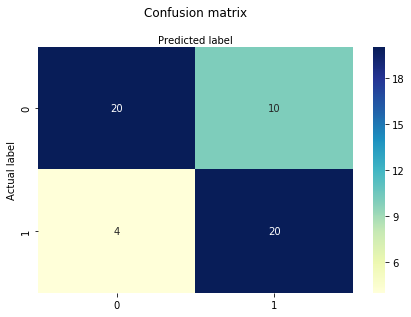

In [127]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [128]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7407407407407407
Precision: 0.6666666666666666
Recall: 0.8333333333333334
Log loss=  0.5480197347315959


In [103]:
# Retrieve the non-normalized game stats
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_data[tourney_data.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,conf_name_t,conf_name_o,top_conf,predicted_result,pred_win_prob
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,76.085714,69.371429,67.893700,0.483704,0.421273,8.171429,8.685714,25.057143,20.457143,20.942857,14.171429,0.724420,11.971429,10.228571,0.742857,112.065942,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,74.454545,71.424242,69.086585,0.432080,0.423374,9.696970,9.000000,23.787879,24.939394,22.787879,25.484848,0.698138,10.424242,14.606061,0.696970,107.769902,Pacific 12,Mountain West,1,1,0.861487
6,2017,32,2017-03-19,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,0,2016,USC,78.222222,73.138889,68.640344,0.455820,0.433794,9.500000,9.750000,23.111111,22.611111,21.861111,14.944444,0.740788,10.861111,12.027778,0.722222,113.959542,Baylor,2016,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,71.852941,63.970588,65.725472,0.466420,0.405561,11.029412,8.558824,22.882353,17.852941,18.823529,16.882353,0.718750,13.000000,10.764706,0.764706,109.322822,Pacific 12,Big 12,0,0,0.297267
28,2014,32,2014-03-22,12,North Dakota State,984e7518-e418-45d5-9797-979b8c2085c1,4,San Diego State,e6914f16-ca37-4d2e-ba26-a425910283e2,0,2013,North Dakota State,73.900000,67.566667,61.735809,0.448276,0.408072,5.250000,9.250000,23.250000,23.500000,19.500000,22.000000,0.756410,9.000000,8.500000,0.766667,119.703623,San Diego State,2013,e6914f16-ca37-4d2e-ba26-a425910283e2,68.205882,58.117647,62.886831,0.419300,0.401551,10.878788,7.906250,21.606061,21.843750,23.969697,16.843750,0.672566,9.060606,12.531250,0.852941,108.458132,Summit League,Mountain West,0,0,0.266246
42,2017,64,2017-03-16,13,East Tennessee State,d750d88f-f7b8-4bc3-a5f6-36e7a67ec93e,4,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,0,2016,East Tennessee State,79.151515,69.727273,72.324275,0.490791,0.416848,8.242424,8.212121,24.484848,21.303030,23.969697,21.272727,0.696587,14.636364,15.363636,0.757576,109.439762,Florida,2016,912f8837-1d81-4ef9-a576-a21f271d4c64,77.888889,66.500000,69.541851,0.449953,0.409749,9.888889,8.861111,23.861111,22.861111,23.638889,19.583333,0.728555,11.583333,14.500000,0.750000,112.002898,Southern,Southeastern,-1,0,0.288146
48,2014,16,2014-03-27,4,UCLA,ec0d6b67-4b16-4b50-92b2-1a651dae6b0f,1,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,0,2013,UCLA,81.162162,70.378378,69.995178,0.488616,0.427009,8.513514,8.486486,24.162162,22.054054,22.675676,20.270270,0.748510,10.189189,14.108108,0.756757,115.953934,Florida,2013,912f8837-1d81-4ef9-a576-a21f271d4c64,69.923077,57.769231,62.876788,0.459630,0.402396,10.102564,8.128205,22.512821,19.512821,22.333333,16.051282,0.668197,10.923077,13.051282,0.923077,111.206502,Pacific 12,Southeastern,0,0,0.304366


In [104]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
missed_predictions[['season_t','round','team','team_seed','conf_name_t', 'opp_team','opp_team_seed', 
                    'conf_name_o','top_conf','predicted_result','game_result','pred_win_prob']]


,season_t,round,team,team_seed,conf_name_t,opp_team,opp_team_seed,conf_name_o,top_conf,predicted_result,game_result,pred_win_prob
224,2017,32,Florida State,3,Atlantic Coast,Xavier,11,Big East,1,1,0,0.816046
140,2015,32,Virginia,2,Atlantic Coast,Michigan State,7,Big Ten,0,1,0,0.802689
260,2017,68,New Orleans,16,Southland,Mount St. Mary's,16,Northeast,0,1,0,0.766418
196,2015,68,North Florida,16,Atlantic Sun,Robert Morris,16,Northeast,0,1,0,0.744945
160,2014,32,Wichita State,1,American Athletic,Kentucky,8,Southeastern,-1,1,0,0.652413
56,2016,64,Pittsburgh,10,Atlantic Coast,Wisconsin,7,Big Ten,0,1,0,0.641291
200,2017,32,Duke,2,Atlantic Coast,South Carolina,7,Southeastern,0,1,0,0.629423
262,2016,32,Stephen F. Austin,14,Southland,Notre Dame,6,Atlantic Coast,-1,1,0,0.584325
60,2014,8,Arizona,1,Pacific 12,Wisconsin,2,Big Ten,0,1,0,0.523829
166,2017,32,Wichita State,10,American Athletic,Kentucky,2,Southeastern,-1,1,0,0.504625


In [42]:
print_game_info(test_games, 2015, 16, 'Duke')

		 Duke 	 Utah
Seed 		      1 	      5
PPG 		  79.26 	  70.91
Allow PPG 	  64.15 	  57.35
Poss Avg 	  66.77 	  62.75
FG % 		  50.16 	  47.75
Allow FG % 	  42.17 	  38.42
Off Rb Avg 	  10.23 	   8.06
Allow Off Rb Avg   9.49 	   8.03
Def Rb Avg 	  24.23 	  23.76
Allow Def Rb Avg  19.51 	  18.53
FT ATT Avg 	  22.38 	  21.82
Allow FT ATT Avg  14.05 	  17.97
FT % 		  69.87 	  70.49
Turnover Avg 	  10.62 	  11.12
Takeaway Avg 	  12.13 	  11.38
Win % 		  89.74 	  73.53
Off Rating 	 118.71 	 113.01


Top Conference=  0
Game Result=  1  (One indicates win for  Duke )
Predicted Result=  0
Predicted Probability=   0.469


In [105]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

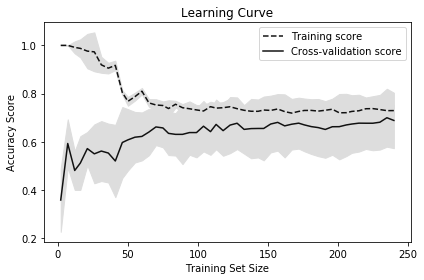

In [106]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Cross Validation Evaluation

In [107]:
scores = cross_val_score(LogisticRegression(), X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.6887362637362637
